In [1409]:
import cv2
import matplotlib.pyplot as plt
import os

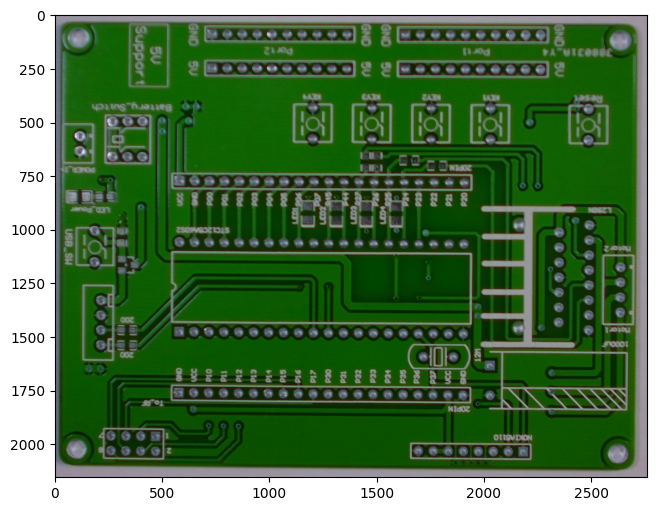

In [1410]:
# read template PCB 01 image
rgb_template_img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/PCB_DATASET/PCB_DATASET/PCB_USED/08.JPG')

# display original template PCB image
plt.figure(figsize=(10,6))
plt.imshow(rgb_template_img, cmap="gray")

In [1411]:
rgb_template_img.shape

(2154, 2759, 3)

In [1412]:
a = int(rgb_template_img.shape[0]/4)
b = int(rgb_template_img.shape[1]/4)

In [1413]:
a,b

(538, 689)

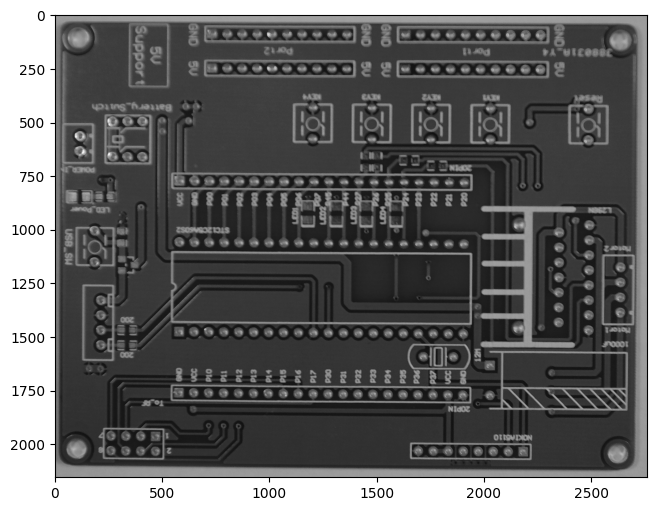

In [1414]:
# read template PCB 01 image as grayscale image
template_img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/PCB_DATASET/PCB_DATASET/PCB_USED/08.JPG', 0)
# the 2nd parameter is flag, makes image grayscale for value 0 or 2

# display the grayscale template PCB image
plt.figure(figsize=(10,6))
plt.imshow(template_img, cmap="gray")

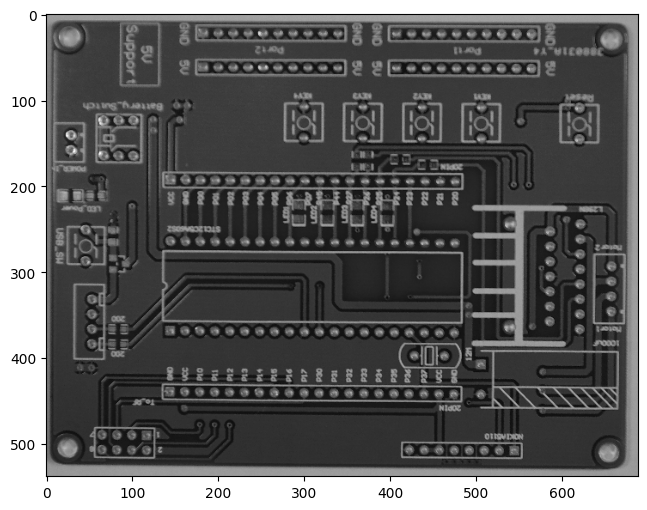

In [1415]:
# resize template image of PCB
template_img_resize = cv2.resize(template_img, (b,a))

# display the grayscale resized template PCB image
plt.figure(figsize=(10,6))
plt.imshow(template_img_resize, cmap="gray")

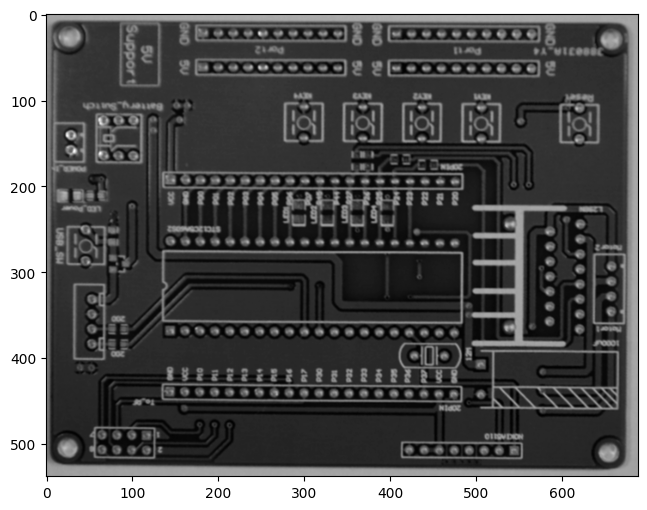

In [1416]:
# Gaussian blur to blur the image before thresholding
blur_template_img = cv2.GaussianBlur(template_img_resize, (3,3),0)

# display the blurred image
plt.figure(figsize=(10,6))
plt.imshow(blur_template_img, cmap="gray")

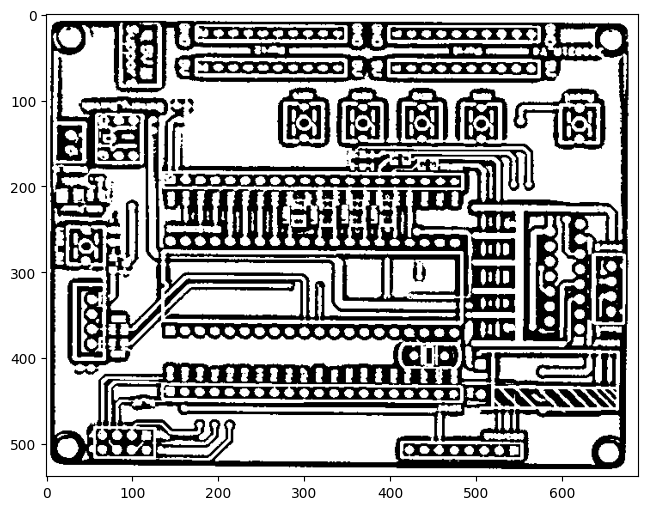

In [1417]:
template_adap_thresh = cv2.adaptiveThreshold(blur_template_img, 255,
                                         cv2. ADAPTIVE_THRESH_MEAN_C,
                                         cv2.THRESH_BINARY, 15, 5)

# display the thresholded image
plt.figure(figsize=(10,6))
plt.imshow(template_adap_thresh, cmap="gray")

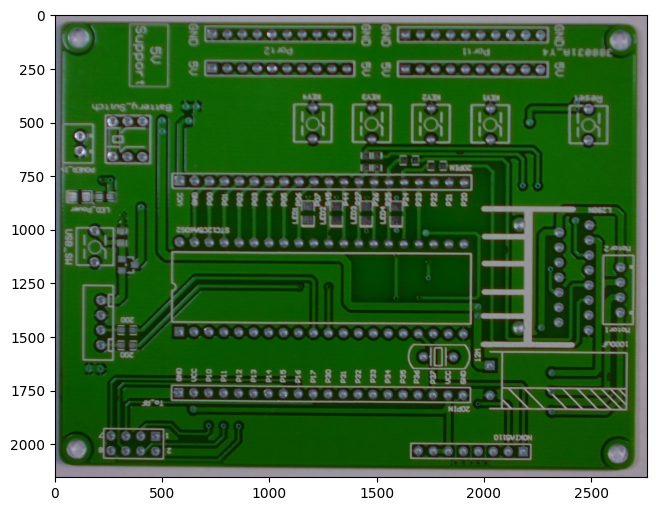

In [1418]:
# read test image of PCB 01
rgb_test_img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/PCB_DATASET/PCB_DATASET/images/Mouse_bite/08_mouse_bite_09.jpg')

# display original test PCB image
plt.figure(figsize=(10,6))
plt.imshow(rgb_test_img, cmap="gray")

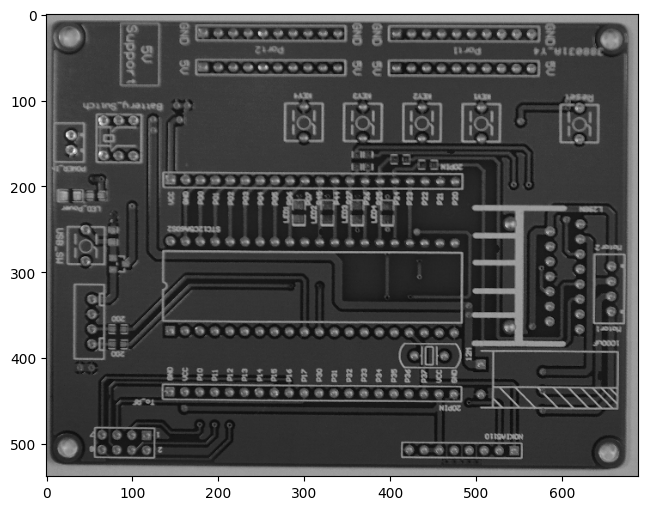

In [1419]:
# read grayscale test PCB image
test_img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/PCB_DATASET/PCB_DATASET/images/Mouse_bite/08_mouse_bite_09.jpg', 0)

# resize test image of PCB
test_img_resize = cv2.resize(test_img, (b,a))

# display the grayscale resized test PCB image
plt.figure(figsize=(10,6))
plt.imshow(test_img_resize, cmap="gray")

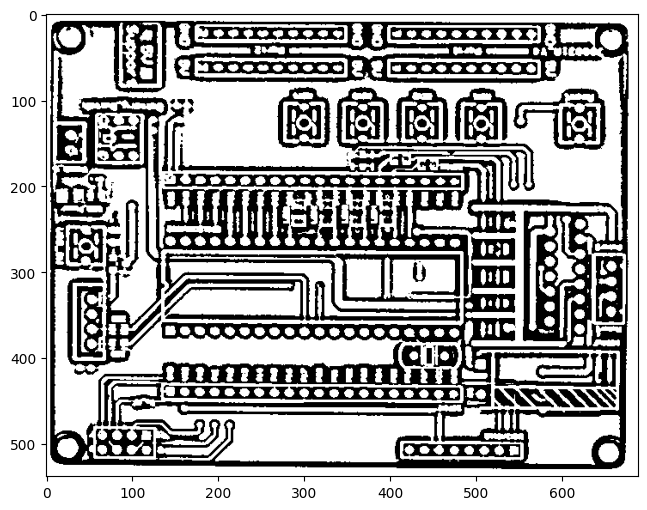

In [1420]:
# Gaussian blur to blur the image before thresholding
blur_test_img = cv2.GaussianBlur(test_img_resize, (3,3),0)

# Adaptive thresholding(mean) on test image
test_adap_thresh = cv2.adaptiveThreshold(blur_test_img, 255,
                                         cv2. ADAPTIVE_THRESH_MEAN_C,
                                         cv2.THRESH_BINARY, 15, 5)

# display the thresholded test image
plt.figure(figsize=(10,6))
plt.imshow(test_adap_thresh, cmap="gray")

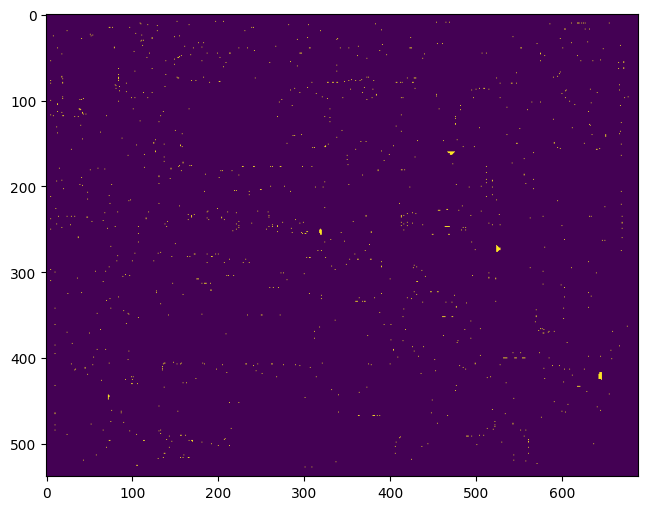

In [1421]:
# Image subtraction (template - test)

sub_img= cv2.subtract(template_adap_thresh,test_adap_thresh)

# display resultant image after subtraction
plt.figure(figsize=(10,6))
plt.imshow(sub_img)

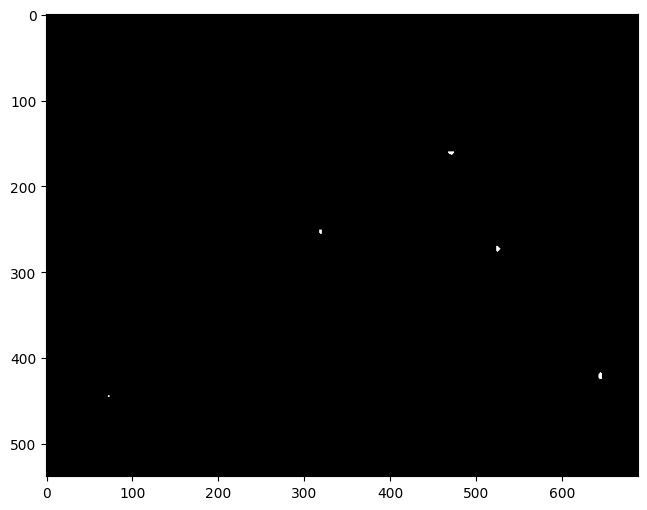

In [1422]:
# Median blur to eliminate background noise
final_img = cv2.medianBlur(sub_img, 3)

# display final binary image result
# to show defects in the image
plt.figure(figsize=(10,6))
plt.imshow(final_img, cmap="gray")

In [1423]:
# contour detection to get the count of defects
cnts = cv2.findContours(final_img, cv2.RETR_LIST,
                        cv2.CHAIN_APPROX_SIMPLE)[-2]
blobs = []
for cnt in cnts:
    if 1<cv2.contourArea(cnt)<300:
        blobs.append(cnt)

print("Number of defects in image:")
print(len(blobs))

Number of defects in image:
4


In [1424]:
orig = test_img_resize
mask_img = final_img

In [1425]:
out_dir = "/content/drive/MyDrive/Colab Notebooks/PCB_DATASET/PCB_DATASET/PCB_USED/.ipynb_checkpoints/Mouse_Bite_Defect"

In [1426]:
import os
os.makedirs(out_dir, exist_ok=True)

In [1427]:
import cv2
_, thresh = cv2.threshold(mask_img, 127, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresh, cv2.RETR_LIST,
cv2.CHAIN_APPROX_SIMPLE)

In [1428]:
h_img, w_img = mask_img.shape[:2]

In [1429]:
mask_img.shape

(538, 689)

In [1430]:
patch_id = 0
for cnt in contours:
    if 1<cv2.contourArea(cnt)<300: # CHANGE ***

      x, y, w, h = cv2.boundingRect(cnt) # bounding rect of defect region [web:8][web:28]

      # Center of defect
      cx = x + w // 2
      cy = y + h // 2

      # Fixed 20x20 box
      bw, bh = 64,64
      x0 = cx - bw // 2
      y0 = cy - bh // 2
      x1 = x0 + bw
      y1 = y0 + bh

      # Clip to image bounds
      x0 = max(0, x0)
      y0 = max(0, y0)
      x1 = min(w_img, x1)
      y1 = min(h_img, y1)

      # Crop from ORIGINAL image using same coords

      patch = orig[y0:y1, x0:x1]

      # Optional: ensure patch is 20x20 (skip if smaller at borders)
      if patch.shape[0] != bh or patch.shape[1] != bw:
        continue

      # Save patch
      out_path = os.path.join(out_dir, f"defect_{patch_id:04d}.png")
      cv2.imwrite(out_path, patch) # save ROI patch [web:21][web:28]
      patch_id += 1